In [12]:
import io
import lzma
import os
import re
import subprocess

from Bio.Data.IUPACData import protein_letters
import Bio.SeqIO

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

In [13]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [14]:
os.makedirs(config['gisaid_mutations_dir'], exist_ok=True)

In [15]:
spikes = list(Bio.SeqIO.parse('data/spike_test.fasta', 'fasta')) 
#spikes = list(Bio.SeqIO.parse('data/springland.fasta', 'fasta')) 

In [16]:
print(f"Read {len(spikes)} spike sequences.")

Read 28 spike sequences.


In [17]:
#spikes_df = (
#    pd.DataFrame({'seqrecord': spikes})
#    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
#            country=lambda x: x['description'].str.split('|').str[-1],
#            host=lambda x: x['description'].str.split('|').str[6].str.strip(),
#            length=lambda x: x['seqrecord'].map(len),
#            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')),
#            )
#    )

In [18]:
spikes_df =pd.DataFrame({'seqrecord': spikes}).assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
                                              country=lambda x: x['description'].str.split('/').str[1],
                                               host='Human', #lambda x: x['description'].str.split('/').str[0].str.strip(),
                                               length=lambda x: x['seqrecord'].map(len),
                                              n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')))

Distribution of length for all spikes:


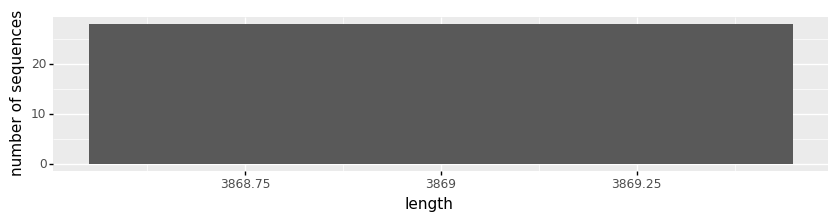


Only keeping spikes with lengths between 3865 and 3870
Here are number of sequences with valid and invalid lengths:


,n_sequences
valid_length,
True,28



Distribution of lengths for sequences with valid and invalid lengths; dotted red lines delimit valid lengths:


C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\facets\facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\facets\facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
C:\Users\fengl\AppData\Roaming\Python\Python39\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed f

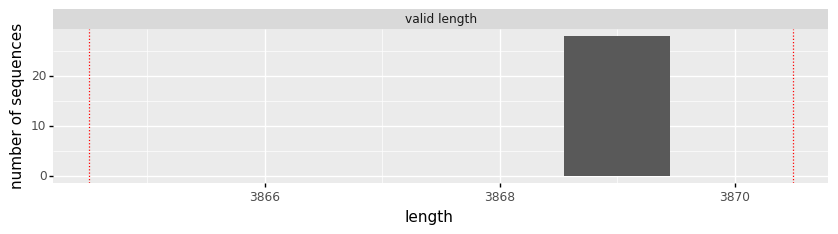

In [19]:
print('Distribution of length for all spikes:')
p = (ggplot(spikes_df) +
     aes('length') +
     geom_bar() +
     ylab('number of sequences') +
     theme(figure_size=(10, 2))
     )
fig = p.draw()
display(fig)
plt.close(fig)

#min_length, max_length = 1260, 1276
min_length, max_length = 3865, 3870
print(f"\nOnly keeping spikes with lengths between {min_length} and {max_length}")
spikes_df = (
    spikes_df
    .assign(valid_length=lambda x: (min_length <= x['length']) & (x['length'] <= max_length))
    )

print('Here are number of sequences with valid and invalid lengths:')
display(HTML(spikes_df
             .groupby('valid_length')
             .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
             .to_html()
             ))

print('\nDistribution of lengths for sequences with valid and invalid lengths; '
      'dotted red lines delimit valid lengths:')
p = (ggplot(spikes_df
            .assign(valid_length=lambda x: x['valid_length'].map({True: 'valid length',
                                                                  False: 'invalid length'}))
            ) +
     aes('length') +
     geom_bar() +
     ylab('number of sequences') +
     theme(figure_size=(10, 2), subplots_adjust={'wspace': 0.2}) +
     facet_wrap('~ valid_length', scales='free') +
     geom_vline(xintercept=min_length - 0.5, color='red', linetype='dotted') +
     geom_vline(xintercept=max_length + 0.5, color='red', linetype='dotted')
     )
fig = p.draw()
display(fig)
plt.close(fig)

spikes_df = spikes_df.query('valid_length')

In [57]:
max_ambiguous = 100
print(f"Filtering sequences with > {max_ambiguous} ambiguous residues")
spikes_df = (
    spikes_df
    .assign(excess_ambiguous=lambda x: x['n_ambiguous'] > max_ambiguous)
    )
display(HTML(
    spikes_df
    .groupby('excess_ambiguous')
    .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
    .to_html()
    ))


Filtering sequences with > 100 ambiguous residues


,n_sequences
excess_ambiguous,
False,28
